<center><h2>Testing the Functionality of the <i>"utils.py"</i> Module</h2></center>

In [1]:
""" Tetsing the following functionality: 
    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)
    * alignment (kabsch)
    * 3d coords (mds)
    -----
    The data files used contain the id of the original
    crystal structures from the RCSB PDB
"""

' Tetsing the following functionality: \n    * metrics (rmsd, gdt_ts, gdt_ha, tmscore)\n    * alignment (kabsch)\n    * 3d coords (mds)\n    -----\n    The data files used contain the id of the original\n    crystal structures from the RCSB PDB\n'

In [1]:
import os
import sys
# science
import numpy as np
import torch
import matplotlib.pyplot as plt
# molecular utils
import mdtraj
# functionality
sys.path.append("../")
from alphafold2_pytorch.utils import *

In [2]:
# load pdb file - has 1 more N_term than it should
prot = mdtraj.load_pdb("data/1h22_protein_chain_1.pdb").xyz[0].transpose()

## Metrics

In [3]:
# alter a small amount and measure metrics
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1

In [4]:
# Numpy
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

# Torch
prot, pred = torch.tensor(prot), torch.tensor(pred)
rmsd     = RMSD(prot, pred)
gdt_ha   = GDT(prot, pred, mode="HA")
gdt_ts   = GDT(prot, pred, mode="TS")
tm_score = TMscore(prot, pred)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [0.57706154]
gdt_ha is:  [0.64676332]
gdt_ts is:  [0.88206339]
tm_score is:  [0.99800758]
rmsd is:  tensor([0.5771], dtype=torch.float64)
gdt_ha is:  tensor([0.6468])
gdt_ts is:  tensor([0.8821])
tm_score is:  tensor([0.9980], dtype=torch.float64)


## Alignment

In [5]:
prot = prot.cpu().numpy()
pred = pred.cpu().numpy()

In [6]:
# rotation matrix
R = np.array([[0.25581, -0.77351, 0.57986],
              [-0.85333, -0.46255, -0.24057],
              [0.45429, -0.43327, -0.77839]])

In [7]:
# perturb protein (translation + rotation + random)
pred = prot + (2*np.random.rand(*prot.shape) - 1) * 1 
pred = np.dot(R, pred)

In [8]:
# check realignment works - torch
pred_mod_, prot_mod_ = kabsch_torch(torch.tensor(pred).double(), torch.tensor(prot).double())
rmsd_torch(prot_mod_, pred_mod_), tmscore_torch(prot_mod_, pred_mod_)

(tensor(0.5767, dtype=torch.float64), tensor(0.1686, dtype=torch.float64))

In [9]:
# check realignment works - numpy
pred_mod, prot_mod = kabsch_numpy(pred, prot)
rmsd_numpy(prot_mod, pred_mod), tmscore_numpy(prot_mod, pred_mod)

(0.5766535823054623, 0.16863808924121826)

## 3d Converter

In [10]:
prot_traj = mdtraj.load_pdb("data/1h22_protein_chain_1.pdb")

In [11]:
prot = prot_traj.xyz[0].transpose()

In [12]:
# works with a simple distance matrix for now
prot = torch.tensor(prot)
dist_mat = torch.cdist(prot.t(), prot.t())

In [13]:
# plt.imshow(distogram, cmap="viridis_r")

In [14]:
# select indices of backbone for angle calculation and selection
N_mask  = prot_traj.topology.select("name == N and backbone")
CA_mask = prot_traj.topology.select("name == CA and backbone") 
C_mask  = prot_traj.topology.select("name == C and backbone") 
CA_mask.shape, N_mask.shape, C_mask.shape

((482,), (482,), (482,))

In [21]:
preds, stresses = MDScaling(dist_mat.cpu(), iters=10, tol=1e-5, fix_mirror=1,
                            N_mask=N_mask, CA_mask=CA_mask, C_mask=C_mask, verbose=2)
pred, stress = preds[0], stresses[0]

it: 0, stress tensor([1.1174e+08], grad_fn=<MulBackward0>)
it: 1, stress tensor([56078112.], grad_fn=<MulBackward0>)
it: 2, stress tensor([51172628.], grad_fn=<MulBackward0>)
it: 3, stress tensor([48687216.], grad_fn=<MulBackward0>)
it: 4, stress tensor([47466740.], grad_fn=<MulBackward0>)
it: 5, stress tensor([46861536.], grad_fn=<MulBackward0>)
it: 6, stress tensor([46540480.], grad_fn=<MulBackward0>)
it: 7, stress tensor([46349444.], grad_fn=<MulBackward0>)
it: 8, stress tensor([46218816.], grad_fn=<MulBackward0>)
it: 9, stress tensor([46116032.], grad_fn=<MulBackward0>)
Corrected mirror in struct no. 0


In [22]:
# check realignment works
pred_mod, prot_mod = Kabsch(pred.numpy(), prot.numpy())
# measure
rmsd     = RMSD(prot_mod, pred_mod)
gdt_ha   = GDT(prot_mod, pred_mod, mode="HA")
gdt_ts   = GDT(prot_mod, pred_mod, mode="TS")
tm_score = TMscore(prot_mod, pred_mod)

print("rmsd is: ", rmsd)
print("gdt_ha is: ", gdt_ha)
print("gdt_ts is: ", gdt_ts)
print("tm_score is: ", tm_score)

rmsd is:  [1.6588651]
gdt_ha is:  [0.35185435]
gdt_ts is:  [0.59554956]
tm_score is:  [0.98402625]


## See reconstruction

In [23]:
new_dist_mat = torch.cdist(pred.t(), pred.t())
delta_dist   = new_dist_mat - dist_mat

Diffs: max = 7.822539806365967 and min -7.046283721923828


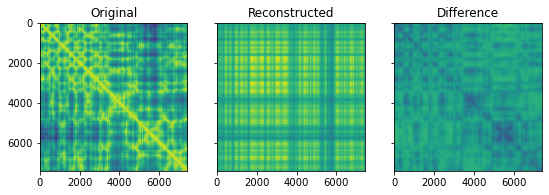

In [24]:
fig, ax = plt.subplots(1,3,figsize=(9, 3), sharey=True)
cmap = plt.get_cmap("viridis_r")

ax[0].set_title("Original")
ax[0].imshow(dist_mat, cmap="viridis_r")
ax[1].set_title("Reconstructed")
ax[1].imshow(new_dist_mat, cmap="viridis_r")
ax[2].set_title("Difference")
ax[2].imshow(delta_dist, cmap="viridis_r")


print("Diffs: max = {0} and min {1}".format(np.amax(delta_dist.numpy()),
                                            np.amin(delta_dist.numpy()) ))

In [45]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein_chain_1.pdb")
buffer_save.xyz = pred_mod.T[None, :, :]
buffer_save.save("data/save_to_check.pdb")

In [46]:
# save pdb file and check manually here: 
# https://molstar.org/viewer/
buffer_save = mdtraj.load("data/1h22_protein_chain_1.pdb")
buffer_save.xyz = prot_mod.T[None, :, :]
buffer_save.save("data/save_to_check_base.pdb")

Legend:
* blue/purple: reference
* green/orange: our reconstruction

Comments: only small blue detail on the left. increase match by decreasing tolerance

<img src="data/comparison.png">